Mehran Rahnamania_400206251
HW4_Q1

In [29]:
%matplotlib inline

In [8]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [10]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?](؟)(را)(و)«ره«و»؟)", r" \1", s)
    return s

In [11]:
def readLangs(lang1):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(lang1, 'r').read().lower().strip().split('\n')
    idx = round(len(lines)/2)
    pairs = []
    pa = []
    unique = []
    g = 0

    for i in range(len(lines)):
        if i % 2 == 0 and i < len(lines)-1:
            if 4 < len(lines[i].split()) < 8:
                pa = [normalizeString(s)for s in lines[i].split('\t')]
                pa.extend([normalizeString(s) for s in lines[i+1].split('\t')])
                pairs.append(pa)

    pairs = pairs[1:]
    unique =[]
    
    for j in  range(len(pairs)):
        for l in pairs[j][0].split() + pairs[j][1].split():
            if l not in unique:
                unique.append(l)
    
    return  pairs, unique

In [12]:
pairs, unique = readLangs("/content/ferdousi.txt")
print("Read %s sentence pairs" % len(pairs))
print(random.choice(pairs))

Reading lines...
Read 41776 sentence pairs
['زبر چون بهشتست و دوزخ به زیر', 'بد ان را که باشد به یزدان دلیر']


In [13]:
SOS_token = 0
EOS_token = 1
unique.sort()
#unique = unique[6:]
word2index = {}
word2count = {}
n_words = 2
index2word = {0: "SOS", 1: "EOS"}

for i, word in enumerate(unique):
    index2word[i+2] = word
    word2index[word] = i+2
    n_words += 1

# GRU

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=8):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [16]:
def indexesFromSentence(word2index, sentence):
    return [word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(word2index, sentence):
    indexes = indexesFromSentence(word2index, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(word2index, pair[0])
    target_tensor = tensorFromSentence(word2index, pair[1])
    return (input_tensor, target_tensor)

In [17]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=8):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    

    return loss.item() / target_length

In [18]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [19]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every


    total_steps = n_iter

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0


    showPlot(plot_losses)

In [28]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [21]:
def evaluate(encoder, decoder, sentence, max_length=8):
    with torch.no_grad():
        input_tensor = tensorFromSentence(word2index, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [22]:
def evaluateRandomly(encoder, decoder, n=10 ):
    for i in range(n):
        pair = random.choice(pairs)
        print( pair[1],'   ', pair[0])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print(output_sentence)
        print('')

In [35]:
n_iter = 20000
print_every = 1000
plot_every=100
learning_rate=0.0001

In [24]:
hidden_size = 300

encoder1 = EncoderRNN(n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, n_words, dropout_p=0.1).to(device)

0m 17s (- 5m 40s) (1000 5%) 4.1303
0m 34s (- 5m 6s) (2000 10%) 4.1388
0m 50s (- 4m 46s) (3000 15%) 4.2055
1m 7s (- 4m 28s) (4000 20%) 4.1350
1m 23s (- 4m 10s) (5000 25%) 4.1862
1m 40s (- 3m 53s) (6000 30%) 4.1369
1m 56s (- 3m 36s) (7000 35%) 4.1493
2m 12s (- 3m 18s) (8000 40%) 4.1927
2m 29s (- 3m 2s) (9000 45%) 4.1309
2m 45s (- 2m 45s) (10000 50%) 4.1754
3m 1s (- 2m 28s) (11000 55%) 4.1711
3m 17s (- 2m 11s) (12000 60%) 4.1508
3m 34s (- 1m 55s) (13000 65%) 4.1899
3m 50s (- 1m 38s) (14000 70%) 4.1301
4m 6s (- 1m 22s) (15000 75%) 4.1513
4m 22s (- 1m 5s) (16000 80%) 4.1756
4m 39s (- 0m 49s) (17000 85%) 4.1078
4m 55s (- 0m 32s) (18000 90%) 4.1822
5m 11s (- 0m 16s) (19000 95%) 4.0730
5m 28s (- 0m 0s) (20000 100%) 4.1115


<Figure size 432x288 with 0 Axes>

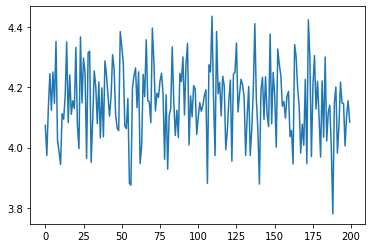

In [38]:
trainIters(encoder1, attn_decoder1, n_iter, print_every=print_every, plot_every=plot_every, learning_rate=learning_rate)

In [39]:
evaluateRandomly(encoder1, attn_decoder1)

سوی سیستان روی بنهاد و تفت     شماساس کز پیش جیحون برفت
بیامد سپهدار خرامید تفت تفت <EOS>

بسی سر به خاک اندر اگنده شد     بسی گنج و گوهر پراگنده شد
ز اگنده و ز اگنده کرد <EOS>

همی باش تا پیش روی سپاه     یلان سینه را گفت برقلبگاه
که تو تو را <EOS>

بترس از گزند و بد روزگار     به گیتی همه تخم زفتی مکار
که در در در در <EOS>

بگردم ببینم جهان را یکی     برانم که گرد زمین اندکی
به و و و <EOS>

ز ترکش براورد تیر خدنگ     چو نزدیک ایرانیان شد بجنگ
پیاده از شد درنگ <EOS>

نگه کرد وزان سان سخنها شنود     چو زروان به گفتار مرد جهود
یکی را را را <EOS>

همه نامداران جوشن وران     ازان پس درامد سپاهی گران
همه مازندران مازندران مازندران سران <EOS>

بدان سان که خونریز بودش دو چنگ     دو دستش بزنار بستم چو سنگ
دو دو دو دو دو دو دو دو

ز بیم وز غم هر زمان بگسلند     شکسته سلیح و گسسته دلند
که و و و <EOS>



# LSTM

In [ ]:
class EncoderRNN2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN2, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, hidden_size)

    def forward(self, input, hidden, c_n):
        embedded = self.embedding(input)
        output = embedded
        output, hidden, c_n = self.lstm(output, hidden, c_n)
        return output, hidden, c_n

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device))

In [ ]:
class AttnDecoderRNN2(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=8):
        super(AttnDecoderRNN2, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
encoder2 = EncoderRNN2(n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN2(hidden_size, n_words, dropout_p=0.1).to(device)

loss = trainIters(encoder2, attn_decoder2, n_iter, print_every=print_every, plot_every=plot_every, learning_rate=learning_rate)

In [ ]:
evaluateRandomly(encoder2, attn_decoder2)